In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from time import time

from keras.models import Model, Input, load_model #model_from_json
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
#from keras.optimizer_v2 import rmsprop
from keras import optimizers
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import StratifiedKFold

import keras.backend as K
from keras.layers import multiply
from keras.layers.core import Dense, Reshape, Lambda, RepeatVector, Permute, Flatten


In [2]:
import lstm_preprocess

## Read the data

In [3]:
data = pd.read_csv("C:\\Users\\Maria\\Desktop\\data\\icd_demos_vitals.csv")

In [4]:
data.drop("Unnamed: 0", axis=1, inplace=True)

In [28]:
#either keep the patients with 24 hours of admission, or change 23 to sth smaller to include patients with less time steps
df = lstm_preprocess.pad(data, 23, 24, 0)

In [6]:
df

,mortality,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,hadm_id,...,18,19,20,F,M,18-25,25-45,45-65,65-89,89+
0,1.0,0.271698,0.331190,0.248120,0.251678,0.144928,0.000000,0.93,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.283019,0.299035,0.240602,0.241611,0.130435,0.000000,0.91,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.275472,0.347267,0.229323,0.238255,0.144928,0.000000,0.94,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.283019,0.344051,0.221805,0.238255,0.260870,0.000000,0.95,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.298113,0.379421,0.323308,0.305369,0.231884,0.000000,0.95,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53131,0.0,0.305660,0.331190,0.203008,0.224832,0.246377,0.872200,0.94,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53132,0.0,0.298113,0.356913,0.195489,0.218121,0.275362,0.000000,0.00,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53133,0.0,0.279245,0.382637,0.233083,0.251678,0.333333,0.000000,0.00,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53134,0.0,0.305660,0.389068,0.236842,0.261745,0.231884,0.000000,0.00,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
print('There are {0} rows in the df after padding'.format(len(df)))

There are 53136 rows in the df after padding


In [8]:
x = df.hadm_id.value_counts() == 23


In [9]:
x[x.values == True]

Series([], Name: hadm_id, dtype: bool)

In [10]:
df[df.hadm_id == 196831]

,mortality,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,hadm_id,...,18,19,20,F,M,18-25,25-45,45-65,65-89,89+


In [11]:
df[df.hadm_id == 196831]

,mortality,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,hadm_id,...,18,19,20,F,M,18-25,25-45,45-65,65-89,89+


In [12]:
#remove unnecessary columns
COLUMNS = lstm_preprocess.delete_columns(df)

In [13]:
COLUMNS

['HeartRate',
 'SysBP',
 'DiasBP',
 'MeanBP',
 'RespRate',
 'TempC',
 'SpO2',
 'Glucose',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 'F',
 'M',
 '18-25',
 '25-45',
 '45-65',
 '65-89',
 '89+']

In [14]:
df.hadm_id.value_counts()

138921.0    24
146105.0    24
189378.0    24
142407.0    24
183558.0    24
            ..
108935.0    24
141092.0    24
172683.0    24
139035.0    24
157802.0    24
Name: hadm_id, Length: 2214, dtype: int64

In [15]:
#reshape the matrix to the appropriate format

MATRIX = df[COLUMNS+['mortality']].values
MATRIX = MATRIX.reshape(int(MATRIX.shape[0]/24),24,MATRIX.shape[1])

In [16]:
MATRIX.shape

(2214, 24, 36)

In [18]:


bool_matrix = (~MATRIX.any(axis=2))
MATRIX[bool_matrix] = np.nan
MATRIX = lstm_preprocess.ZScoreNormalize(MATRIX)

## restore 3D shape to boolmatrix for consistency
bool_matrix = np.isnan(MATRIX)
MATRIX[bool_matrix] = 0 
   
#permutation = np.random.permutation(MATRIX.shape[0])
#MATRIX = MATRIX[permutation]
#bool_matrix = bool_matrix[permutation]

X_MATRIX = MATRIX[:,:,0:-1]
Y_MATRIX = MATRIX[:,:,-1]
sc = MinMaxScaler()
#x_bool_matrix = bool_matrix[:,:,0:-1]
#y_bool_matrix = bool_matrix[:,:,-1]

(2214, 24)
(2214, 24, 35)
(35,)
(35,)
(2214, 24, 35)
(2214, 24, 35)
(2214, 24, 1)
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\data_extraction\lstm_preprocess.py:78: RuntimeWarning: invalid value encountered in true_divide
  x_matrix = x_matrix / stds


In [19]:
len(Y_MATRIX)

2214

In [20]:
#train, validation, test split

tt_split = 0.7 
val_percentage = 0.8

X_TRAIN = X_MATRIX[0:int(tt_split*X_MATRIX.shape[0]),:,:]
Y_TRAIN = Y_MATRIX[0:int(tt_split*Y_MATRIX.shape[0]),:]
Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], Y_TRAIN.shape[1], 1)

X_VAL = X_MATRIX[int(tt_split*X_MATRIX.shape[0]):int(val_percentage*X_MATRIX.shape[0])]
Y_VAL = Y_MATRIX[int(tt_split*Y_MATRIX.shape[0]):int(val_percentage*Y_MATRIX.shape[0])]
Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], Y_VAL.shape[1], 1)
"""
x_val_boolmat = x_bool_matrix[int(tt_split*x_bool_matrix.shape[0]):int(val_percentage*x_bool_matrix.shape[0])]
y_val_boolmat = y_bool_matrix[int(tt_split*y_bool_matrix.shape[0]):int(val_percentage*y_bool_matrix.shape[0])]
y_val_boolmat = y_val_boolmat.reshape(y_val_boolmat.shape[0],y_val_boolmat.shape[1],1)
"""
X_TEST = X_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
Y_TEST = Y_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], Y_TEST.shape[1], 1)
"""
x_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]
y_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]
y_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)

X_TEST[x_test_boolmat] = 0
Y_TEST[y_test_boolmat] = 0
"""

'\nx_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]\ny_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]\ny_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)\n\nX_TEST[x_test_boolmat] = 0\nY_TEST[y_test_boolmat] = 0\n'

In [21]:
len(Y_TRAIN)

1549

In [22]:
Y_TRAIN[0]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [26]:
Y_TRAIN

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

In [27]:
no_feature_cols = X_TRAIN.shape[2]


## A simple LSTM

In [155]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=7, output_summary=False):
  
  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  
  model = keras.Sequential()
  model.add(layers.LSTM(256, return_sequences=True, input_shape = (time_steps, no_feature_cols)))
  model.add(layers.Dense(1, activation="sigmoid"))
  optimizer = tensorflow.keras.optimizers.RMSprop()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model



In [156]:
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24)

time_steps:24|no_feature_cols:35
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 24, 256)           299008    
_________________________________________________________________
dense_7 (Dense)              (None, 24, 1)             257       
Total params: 299,265
Trainable params: 299,265
Non-trainable params: 0
_________________________________________________________________


In [160]:
  #init callbacks
  tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

  #Make checkpoint dir and init checkpointer
  checkpoint_dir = "./saved_models/{0}".format('model_name')

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

  #fit
history_reg = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

Epoch 1/100
159/159 [==============================] - 7s 44ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 7.5032 - val_acc: 0.7842
Epoch 2/100
159/159 [==============================] - 5s 28ms/step - loss: 0.0026 - acc: 0.9993 - val_loss: 7.7293 - val_acc: 0.8027
Epoch 3/100
159/159 [==============================] - 4s 27ms/step - loss: 0.0067 - acc: 0.9991 - val_loss: 7.8527 - val_acc: 0.7935
Epoch 4/100
159/159 [==============================] - 4s 28ms/step - loss: 0.0024 - acc: 0.9994 - val_loss: 7.8116 - val_acc: 0.7910
Epoch 5/100
159/159 [==============================] - 5s 29ms/step - loss: 0.0022 - acc: 0.9995 - val_loss: 8.1816 - val_acc: 0.7898
Epoch 6/100
159/159 [==============================] - 4s 26ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 8.0544 - val_acc: 0.7921
Epoch 7/100
159/159 [==============================] - 4s 27ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 8.3520 - val_acc: 0.7884
Epoch 8/100
159/159 [==============================] - 4s 26ms

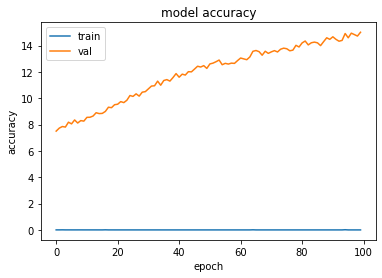

In [162]:
from matplotlib import pyplot as plt
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED, (Y_PRED.shape[0],  Y_PRED.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
#print(confusion_matrix(val, pred))
print('Validation Accuracy')
print(accuracy_score(val, np.around(pred)))
print('ROC AUC SCORE VAL')
print(roc_auc_score(val, pred))

TARGET: mortality
Validation Accuracy
0.7292817679558011
ROC AUC SCORE VAL
0.6049445354614075
              precision    recall  f1-score   support

           0       0.30      0.18      0.23        65
           1       0.31      0.22      0.25        65
           2       0.32      0.20      0.25        65
           3       0.32      0.20      0.25        65
           4       0.33      0.22      0.26        65
           5       0.33      0.22      0.26        65
           6       0.36      0.25      0.29        65
           7       0.36      0.25      0.29        65
           8       0.36      0.25      0.29        65
           9       0.35      0.25      0.29        65
          10       0.35      0.25      0.29        65
          11       0.34      0.25      0.29        65
          12       0.34      0.25      0.29        65
          13       0.35      0.25      0.29        65
          14       0.33      0.23      0.27        65
          15       0.33      0.23      0.

## Add regularization

In [164]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=7, output_summary=False):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 

  model = keras.Sequential()
  model.add(layers.LSTM(256, return_sequences=True, input_shape = (time_steps, no_feature_cols)))
  model.add(layers.Dense(1, activation="sigmoid"))
  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

time_steps:24|no_feature_cols:35
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24, 256)           299008    
_________________________________________________________________
dense_9 (Dense)              (None, 24, 1)             257       
Total params: 299,265
Trainable params: 299,265
Non-trainable params: 0
_________________________________________________________________
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\.venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
159/159 [==============================] - 14s 62ms/step - loss: 0.4398 - acc: 0.8299 - val_loss: 0.4493 - val_acc: 0.8061
Epoch 2/100
159/159 [==============================] - 4s 28ms/step - loss: 0.3850 - acc: 0.8490 - v

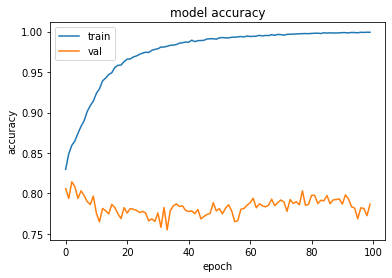

In [169]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model with Attention (got it from the 1st paper on our reference list so i need to double check it as i just copy pasted it)

In [170]:
def Attention(inputs, TIME_STEPS):
    """
    inputs.shape = (batch_size, time_steps, input_dim)
    """ 
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [171]:
def build_model(no_feature_cols=None, time_steps=7, output_summary=False):
  
  """
  Assembles RNN with input from return_data function
  Args:
  ----
  no_feature_cols : The number of features being used AKA matrix rank
  time_steps : The number of days in a time block
  output_summary : Defaults to False on returning model summary
  Returns:
  ------- 
  Keras model object
  """
  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  input_layer = Input(shape=(time_steps, no_feature_cols)) 
  x = Attention(input_layer, time_steps)
  x = Masking(mask_value=0, input_shape=(time_steps, no_feature_cols))(x) 
  x = LSTM(256, return_sequences=True)(x)
  preds = TimeDistributed(Dense(1, activation="sigmoid"))(x)
  model = Model(inputs=input_layer, outputs=preds)
  #opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
  #RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model


In [172]:
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24)

time_steps:24|no_feature_cols:35
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 35)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 35, 24)       0           input_4[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 35, 24)       0           permute[0][0]                    
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 35, 24)       600         reshape[0][0]                    
___________________________________________________________

In [176]:
  #init callbacks
  tb_callback = TensorBoard(log_dir='./logs/{0}_{1}.log'.format('model_name', time),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

  #Make checkpoint dir and init checkpointer
  checkpoint_dir = "./saved_models/{0}".format('model_name')

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

  #fit
  hist = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    #callbacks=[tb_callback], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)


Epoch 1/100
159/159 [==============================] - 5s 29ms/step - loss: 0.3699 - acc: 0.8503 - val_loss: 0.4275 - val_acc: 0.8276
Epoch 2/100
159/159 [==============================] - 4s 28ms/step - loss: 0.3642 - acc: 0.8549 - val_loss: 0.4490 - val_acc: 0.8270
Epoch 3/100
159/159 [==============================] - 4s 28ms/step - loss: 0.3616 - acc: 0.8538 - val_loss: 0.4109 - val_acc: 0.8159
Epoch 4/100
159/159 [==============================] - 4s 28ms/step - loss: 0.3589 - acc: 0.8557 - val_loss: 0.4222 - val_acc: 0.8215
Epoch 5/100
159/159 [==============================] - 4s 28ms/step - loss: 0.3575 - acc: 0.8572 - val_loss: 0.4290 - val_acc: 0.8094
Epoch 6/100
159/159 [==============================] - 5s 29ms/step - loss: 0.3512 - acc: 0.8572 - val_loss: 0.4252 - val_acc: 0.8188
Epoch 7/100
159/159 [==============================] - 5s 29ms/step - loss: 0.3536 - acc: 0.8610 - val_loss: 0.4262 - val_acc: 0.8053
Epoch 8/100
159/159 [==============================] - 5s 29ms

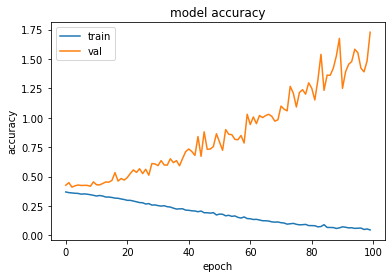

In [178]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('./saved_models/{0}.h5'.format('model_name'))


print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_TRAIN, (Y_TRAIN.shape[0],  Y_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
#print(confusion_matrix(val, pred))
print('Validation Accuracy')
print(accuracy_score(train, np.around(pred)))
print('ROC AUC SCORE VAL')
print(roc_auc_score(train, pred))
#print('CLASSIFICATION REPORT VAL')
#print(classification_report(val, np.around(pred)))